In [1]:
from classes.vqa_model_builder import VqaModelBuilder
from common.utils import VerboseTimer

import IPython
from IPython.display import Image, display
from common.functions import get_highlighted_function_code
import vqa_logger 

Using TensorFlow backend.


In [2]:
# TODO: Do we need this?
from keras import backend as keras_backend
keras_backend.clear_session()

In [3]:
# loss, activation = 'categorical_crossentropy', 'softmax' # good for a model to predict multiple mutually-exclusive classes:
# loss, activation = 'binary_crossentropy', 'sigmoid'
# loss, activation = 'categorical_crossentropy', 'sigmoid'
# loss, activation = 'cosine_proximity', 'relu'
loss, activation, lstm_units = 'cosine_proximity', 'tanh', 0


categorical_data_frame_name = 'answers'
# categorical_data_frame_name = 'words'

with VerboseTimer("Instantiating VqaModelBuilder"):
    mb = VqaModelBuilder(loss, activation, lstm_units=lstm_units, categorical_data_frame_name=categorical_data_frame_name)

[2019-02-22 13:46:43][DEBUG] Instantiating VqaModelBuilder: 0:00:00.107399


#### What does the data looks like?

In [4]:
mb.categorical_data_frame.sample(5)

,answer
1197,lesions external auditory (ear) canal
613,choroid plexus cyst
1110,renal infarct
699,ruptured aortic aneurysm
129,tuberous sclerosis complex (tsc)


#### Before we start, lets take a look at the functions that will create the model:

##### word_2_vec_model
Define how to build the word-to vector branch:

In [5]:
code = get_highlighted_function_code(VqaModelBuilder.word_2_vec_model,remove_comments=True)
IPython.display.display(code)  

##### get_image_model:
In the same manner, defines how to build the image representation branch:

In [6]:
code = get_highlighted_function_code(VqaModelBuilder.get_image_model,remove_comments=False)
IPython.display.display(code)  

##### And the actual function for getting the model:

In [7]:
code = get_highlighted_function_code(mb.get_vqa_model,remove_comments=True)
IPython.display.display(code)  

### Creating the model

In [8]:
with VerboseTimer("Gettingt the model"):
    model = mb.get_vqa_model()

[2019-02-22 13:46:43][DEBUG] Getting embedding (lstm model)
[2019-02-22 13:46:43][DEBUG] Creating Embedding model
[2019-02-22 13:46:43][DEBUG] Done Creating Embedding model
[2019-02-22 13:46:43][DEBUG] Getting image model
[2019-02-22 13:46:46][DEBUG] merging final model


C:\Users\avitu\Documents\GitHub\VQA-MED\VQA-MED\VQA.Python\classes\vqa_model_builder.py:123: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`
  fc_model = Model(inputs=[lstm_input_tensor, image_input_tensor], output=fc_tensors)


[2019-02-22 13:46:47][DEBUG] Gettingt the model: 0:00:03.386876


#### We better save it:

##### The saving function:

In [9]:
code = get_highlighted_function_code(VqaModelBuilder.save_model,remove_comments=False)
IPython.display.display(code)  

In [10]:
model_folder = VqaModelBuilder.save_model(model, mb.categorical_data_frame_name)

[2019-02-22 13:46:47][DEBUG] model saved
[2019-02-22 13:46:47][DEBUG] saving prediction vector
[2019-02-22 13:46:47][DEBUG] saved prediction vector
[2019-02-22 13:46:47][DEBUG] Writing Summary
[2019-02-22 13:46:47][DEBUG] Done Writing Summary
[2019-02-22 13:46:47][DEBUG] Saving image
[2019-02-22 13:46:48][DEBUG] Image saved ('C:\Users\Public\Documents\Data\2019\models\20190222_1346_47\model.png')
[2019-02-22 13:46:48][INFO] Summary: C:\Users\Public\Documents\Data\2019\models\20190222_1346_47\model_summary.txt
Image: C:\Users\Public\Documents\Data\2019\models\20190222_1346_47\model.png

[2019-02-22 13:46:48][INFO] model_location = 'C:\Users\Public\Documents\Data\2019\models\20190222_1346_47\vqa_model.h5'


### Display a plot + summary:

#### Where are the trainable parameters?

##### The function:

In [11]:
code = get_highlighted_function_code(VqaModelBuilder.get_trainable_params_distribution,remove_comments=False)
IPython.display.display(code)

In [12]:
top = VqaModelBuilder.get_trainable_params_distribution(model)

Got a total of 120,220 trainable parameters


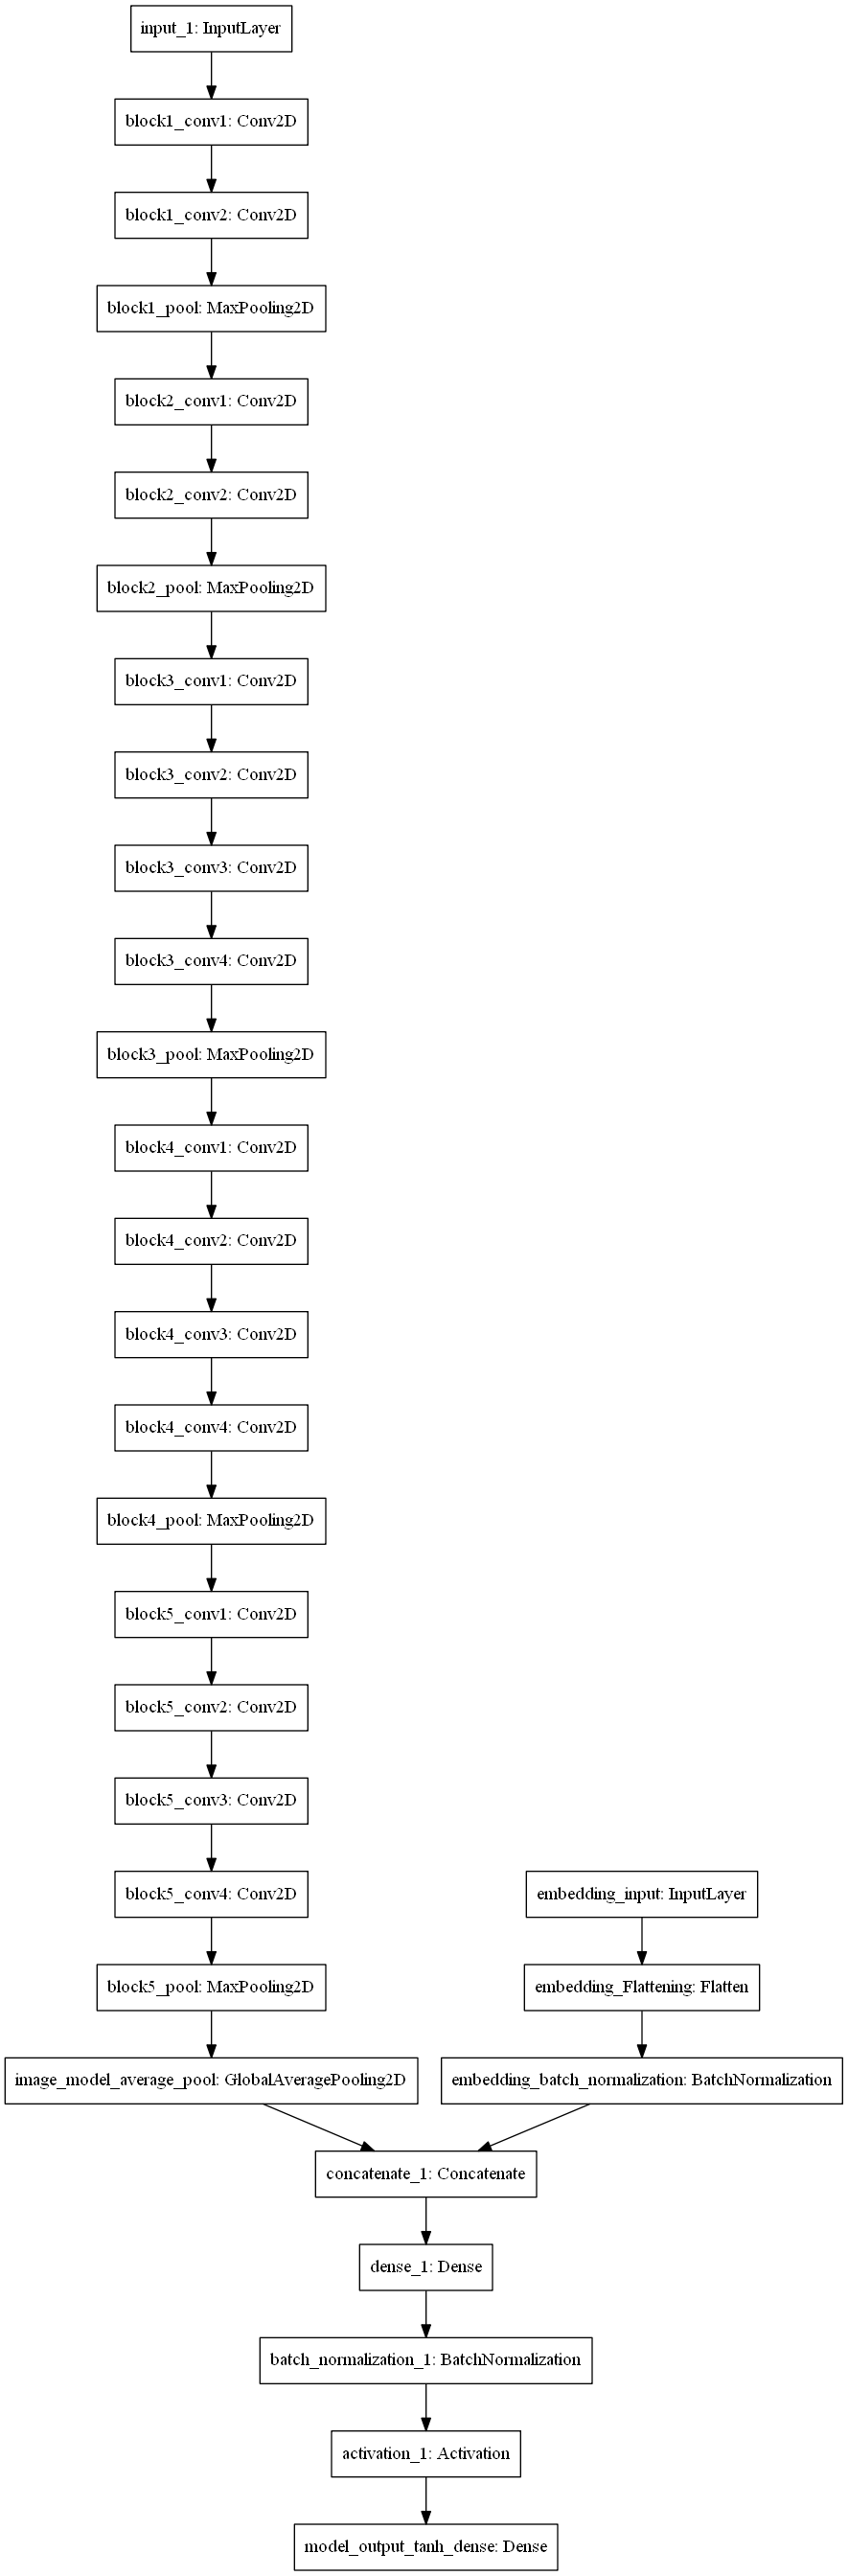

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [13]:
display(Image(filename=str(model_folder.image_file_path)))
model.summary()

Copy these items to the next notebook of training the model

In [14]:
msg = f"Summary: {str(model_folder.summary_path)}\n"
msg += f"Image: {model_folder.image_file_path}\n"
location_message = f"model_location = '{model_folder.model_path}'"


print(msg)
print(location_message.replace('\\', '\\\\'))

Summary: C:\Users\Public\Documents\Data\2019\models\20190222_1346_47\model_summary.txt
Image: C:\Users\Public\Documents\Data\2019\models\20190222_1346_47\model.png

model_location = 'C:\\Users\\Public\\Documents\\Data\\2019\\models\\20190222_1346_47\\vqa_model.h5'
